# "Are we in a time loop?"


---
**Table of contents**
- [Part 1: Filtering and processing data](#Part-1:-Filtering-and-processing-data)
  - [1. Importing the data](#**1.-Importing-the-data**)
  - [2. Processing the release date column](#**2.-Processing-the-release-date-column**)
  - [3. Processing the genre column](#**3.-Processing-the-genre-column**)
  - [4. Processing the country column](#**4.-Processing-the-country-column**)
  - [5. Merging additional dataset](**5.-Merging-additional-dataset**)
- [Part 2: Getting to know the data: visualisation](#Part-2:-Getting-to-know-the-data:-visualisation)
  - [1. General visualization](#**1.-General-visualization**)
  - [2. Looking for peaks in months for specific genres](#**2.-Looking-for-peaks-in-months-for-specific-genres**)
  - [3. Evolution of the box office throughout the months](#**3.-Evolution-of-the-box-office-throughout-the-months**)
- [Part 3: Hypothesis testing](#Part-3:-Hypothesis-testing)
  - [1. Relation between the number of horror movies and the release month](#**1.-Relation-between-the-number-of-horror-movies-and-the-release-month**)
  - [2. Relation between the number of Family movies and the release month](#**2.-Relation-between-the-number-of-Family-movies-and-the-release-month**)
  - [3. Relation between the number of Romance and the release month](#**3.-Relation-between-the-number-of-Romance-and-the-release-month**)
- [Part 4: Causal analysis, does the film industry support the time loop ?](#Part-4:-Causal-analysis,-does-the-film-industry-support-the-time-loop-?)
  - [1. Process the dataframe](#**1.-Process-the-dataframe**)
  - [2. Horror movies revenue in October](#**2.-Horror-movies-revenue-in-October**)
  - [3. Family movies revenue in July, November, December](#**3.Family-movies-revenue-in-July,-November,-December**)




---
## Part 1: Filtering and processing data
The first step of the analysis is to filter the dataframe 'movie.metadata', and to reshape it so that relevant features are easily accessible for further analysis.


---
### **1. Importing the data**
We will import the main frame as well as additional frame, and perform merging, and primary filtering.


#### **1.1. Importing Movie data**


In [1]:
# Import useful libraries and helpers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf

from helpers2 import *


In [2]:
# Import the 'movie.metadata' main frame

#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload

MOVIE_PATH = 'Data/movie.metadata.tsv'
col_names = ['Wikipedia movieID', 'Freebase movieID', 'Movie name', 'Movie release date', 'Movie box office revenue','Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres' ]
df_movies = pd.read_csv(MOVIE_PATH, sep='\t', names = col_names)
df_origin = df_movies.copy(deep = True) # copying the original dataset to compare later
display(df_movies.head(1))

,Wikipedia movieID,Freebase movieID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


#### **1.2. Importing additionnal data : Budget and Ratings**



In [8]:
#Set paths
BUDGET_PATH = 'Data/additional_data/movies_metadata.csv'
RATING_PATH = "Data/additional_data/title.ratings.tsv"
IMDB_DATA_PATH = "Data/additional_data/title.basics.tsv"

# Loading the data
df_budget = pd.read_csv(BUDGET_PATH, sep=',', header=0, usecols=["id", "budget", "original_title", "release_date", "runtime"])
#df_rating = pd.read_table(RATING_PATH, sep='\t')
#df_imdb_data = pd.read_table(IMDB_DATA_PATH, sep='\t', usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"])


---
### **2. Processing the release date column**

In order to perform a study on month of release, we need to check what is the proportion of movies which don't have the month of release. If this proportion is not too high, we can continue our analysis. We then need to process the release date column so that the year, season and month of release are easily accessible.


#### **2.1. Percentage missing month per year** 



Now that the year of release is accessible, the percentage of missing month per year can be computed, so that we can understand better its evolution.

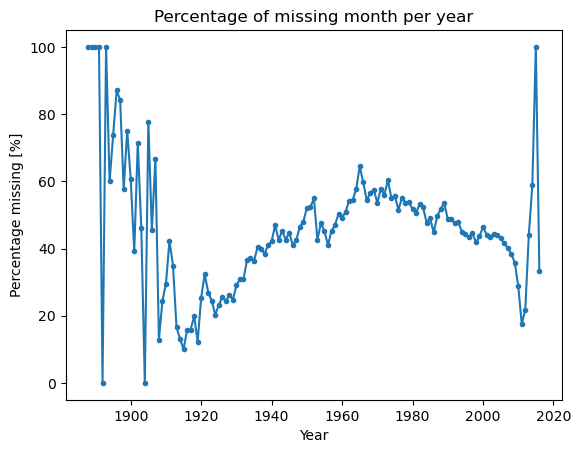

In [9]:
df_without_years = df_movies.copy(deep = True)
df_movies = select_years(df_movies)
plot_percentage_missing_month_per_year(df_movies)

In the initial 20 years, the annual percentage of missing months is important and exhibits significant variation. Beginning in the 1920s, it steadily rises from 10% to 60% in the 1960s, followed by a decline to 40% in the 2000s.

#### **2.2. Proportion of data with a release month**

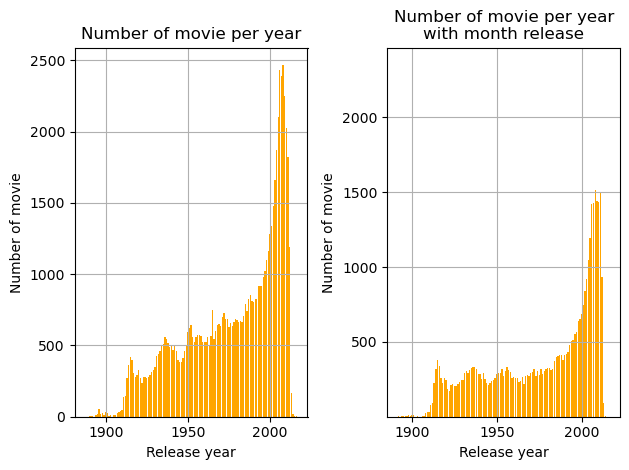

In [10]:
df_without_months = df_movies.copy(deep=True)
df_movies = dataframe_with_months(df_movies)

nmbr_movie_years(df_without_months,df_movies)

In the first plot, the number of movie releases shows a continuous increase from the 1920s to the 1980s, while in the second plot, it remains constant. Starting from the 1980s, both plots exhibit a notable surge in the number of released movies. The period before the 1920s does not show a significantly high number of movie releases. These observations align with the trends depicted in the 'Percentage of missing month per year' plot above.

#### **2.3. Selecting only the years with enough movies**



We observe that many years have a relatively low number of movie releases. Given our focus on a yearly analysis, we will exclude years with less than 200 movie releases.


In [11]:
df_without_main_years = df_movies.copy() 

# Takes out all the years where the number of movies is under 200
df_movies = select_main_years(df_movies)

# Compute the ratio of usable data
ratio = len(df_movies)*100/len(df_origin)
print(f"The number of movie kept is : {len(df_movies)}\nWhich corresponds to a ratio of : {ratio:.2f}%")

The number of movie kept is : 41855
Which corresponds to a ratio of : 51.20%


The data which has a release month represent 51.20% of the entire dataframe, and 41 855 movies, which is an acceptable number for our study. We can then go further in the analysis.



On the right is the new dataset, with all rows which have a known month of release.

#### **2.4. Splitting the release date column** 


The release month is extracted in the cell 'Movie release month' as well as the season.



**Note:** to denote the season, a number between 1 and 4 is assigned following: 
- 1 : Winter
- 2 : Spring
- 3 : Summer
- 4 : Autumn

In [12]:
# The release date column is separated into 2 columns for the month, and year of release

df_without_clean_date_season = df_movies.copy(deep = True)
df_movies = clean_date_and_season(df_movies)
display(df_movies.head(1))


,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Movie release month,Movie release season
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,1,1


---
### **3. Processing the genre column**

Now that the date column is cleaned, the genre column needs also to be processed. The final goal is to assign to each movie 2 main genres which are relevant for our analysis. 


**Note**: The computational time to perform this filtering is very large because of the iteration over all rows of the dataframe. Indeed, the json format of each cells forces us to iterate over each rows.



#### **3.1. Gathering all genres and their occurrences**


In order to assign a main genre to each movie, we first need to find all the genres and their occurrences, to understand better how the genre data is organised. To do so, the frame 'nb_genres' is created using the function 'counting_genres', by iterating over 'df_clean_date', and contains each genre name with their respective occurrence.


In [13]:
nb_genres = counting_genres(df_movies)
nb_genres.head(20)

,genre name,nb of movies
0,Drama,18700
1,Comedy,9893
2,Romance Film,6123
3,Black-and-white,5438
4,Thriller,5272
5,Action,5026
6,Crime Fiction,4212
7,Short Film,4114
8,Indie,4054
9,World cinema,3297


Let's plot the number of movies per genre, for all the different genres we found (the genres are denoted by their index, 0 being the most used genre).

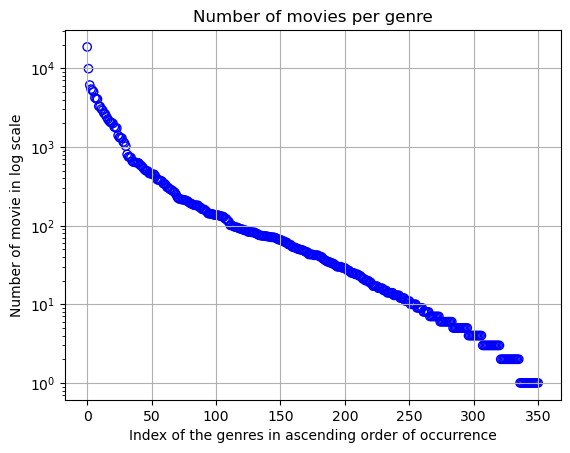

In [14]:
nb_movies_genres(nb_genres)

The 'nb_genres' frame shows that there are 351 different genres, and their occurrence decays as a power law. Indeed, as seen in the above plot, from the 100th genre, there are only 100 or less movies associated to it. This means that taking into account only the first genres will still describe most of the data.

#### **3.2. Creating main genres clusters**



In the 'nb_genres' frame, one can see that some genres could be grouped together in order to form a bigger group of data. For example, the genre 'Comedy' defines 9893 movies, and the genre 'Comedy film' defines 2423 movies, whereas they could be grouped together. 
Moreover, 8 main genres are chosen to describe the data: 
- Drama
- Comedy
- Romance
- Thriller
- Action
- Family film
- Horror
- Informative

These genres are chosen because they define a high proportion of data, and also because they are the ones which will be relevant further in our study, when the genre of a movie will be presented with respect to the month of release.

The function 'main_genres_cluster' creates the respective genre clusters, and gathers them in a 'main_genres' frame.

The dictionary 'genres_lexical_field' gathers, for each main genre, a lexical field, which allow to find the associated sub-genres. It is then used as input of the function 'main_genres_cluster'.

In [15]:

genres_lexical_field = {'Drama': ['Drama'], 'Comedy': ['Comedy','Slapstick','Parody'],'Romance':['Romance','Romantic'], 
                        'Thriller':['Thriller','Crime'],'Action':['Action','Adventure','War','Western'],'Family film':['Family','Animation'],
                        'Horror':['Horror'],'Informative':['Documentary','Biography','Biopic','History']}
main_genres = main_genres_cluster(genres_lexical_field,nb_genres)


#### **3.3. Assigning up to 2 main genres to each movie**

The goal now is to assign main genres to each movies. The function 'reshape_genres_column' uses the 'main_genres' frame and iterates over all row of the original dataframe, in order to assign up to two main genres to each movie. 

In [16]:
df_movies = reshape_genre_column(df_movies,main_genres)
df_movies.head(1)

,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,Movie release season,genre 1,genre 2
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,1,1,None,None


---
### **4. Processing the country column**

Now that the genre column is cleaned, the country column needs also to be processed. The final goal is to assign to each movie 1 continent. 


We process it in the same way as for the genre column

In [17]:
df_movies = adding_continents(df_movies)
df_movies.head(1)


We don't classify countries with less than 5 movies which represents 103 movies
 Only 2895 movies have 2 continents so we take only continent 1 into consideration 
northa -> 1
Europe -> 2
southa -> 3
Asia -> 4
Africa -> 5


,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,Movie release season,genre 1,genre 2,continent_1
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,1,1,None,None,1.0


---
### **5. Merging additional dataset**
For Part 4 (causal analysis), the budget needs to be taken into account, therefore an additional dataset is merged to the original one.

#### **5.1. Preparing the datasets for merging**

In [18]:
# Rename columns of interest so they match our main dataset
df_budget = df_budget.rename(columns={"original_title": "Movie name", "runtime": "Movie runtime", "release_date": "Movie release date"})
#df_imdb_data = df_imdb_data.rename(columns={"startYear": "Movie release year", "originalTitle": "Movie name", "runtimeMinutes": "Movie runtime"})

# Modify the 'release_date' column to extract the movie release year column
df_budget['Movie release date'] = pd.to_datetime(df_budget['Movie release date'],errors='coerce')

# Drop any NaN values from the 3 columns of interest
df_movies = df_movies.dropna(subset=['Movie name'])
df_budget = df_budget.dropna(subset=['Movie release date','Movie name'])

#df_imdb_data.loc[df_imdb_data["Movie release year"] == "\\N", "Movie release year"] = np.nan
#df_imdb_data = df_imdb_data[df_imdb_data["Movie release year"].notna()]

# Extract the Movie release year
df_budget['Movie release year'] = df_budget['Movie release date'].dt.year 

# Convert release year to 'int64'
df_budget["Movie release year"] = df_budget["Movie release year"].astype("int64", errors="ignore")
#df_imdb_data["Movie release year"] = df_imdb_data["Movie release year"].astype("int64")

# Remove duplicates
df_movies = df_movies.drop_duplicates(subset=["Movie name", "Movie release year"])
df_budget = df_budget.drop_duplicates(subset=["Movie name", "Movie release year"])
#df_imdb_data = df_imdb_data.drop_duplicates(subset=["Movie name", "Movie release year"])


#### **5.2. Merging**

In [19]:
# Merge movies and budget by combining 'Movie name', 'Movie release year'
df_movies_merged = df_movies.merge(df_budget,on = ['Movie name', 'Movie release year'])

# Merge 'imdb_movies' with 'imdb_ratings':
#ratings_extd = pd.merge(left=df_imdb_data, right=df_rating, on="tconst")

# Merge movies with ratings
#df_movies_merged = pd.merge(left=df_movies_merged, right=ratings_extd, how="left", on=['Movie name', 'Movie release year'])

print("Original dataset is of length : ", len(df_movies))
print("Merged dataset is of length : ", len(df_movies_merged))
display(df_movies_merged.head(1))

Original dataset is of length :  41807
Merged dataset is of length :  12718


,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime_x,Movie languages,Movie countries,Movie release year,Movie release month,Movie release season,genre 1,genre 2,continent_1,budget,id,Movie release date,Movie runtime_y
0,13405420,/m/03c482v,The Battle at Elderbush Gulch,NaN,29.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,11,4,Action,None,1.0,0,125673,1913-01-01,29.0


The merging reduce the length from ~40 000 to ~12 000. by merging the main frame with the one with the budget. \
To visualize tendencies in our dataset we will use the original one with more movies. \
We will use the merged dataset when we have interest in budget (see part 4).

---
## Part 2: Getting to know the data: visualisation

The purpose of this part is to get a feeling of main tendencies of our dataset when looking through monthly evolution. Some visualizations are needed to get a first answer to our intuition. We will focus on the genre distribution over month, and also look at the box office revenue distribution.

---
### **1. General visualization**
The following figure shows some general visualization about our data.

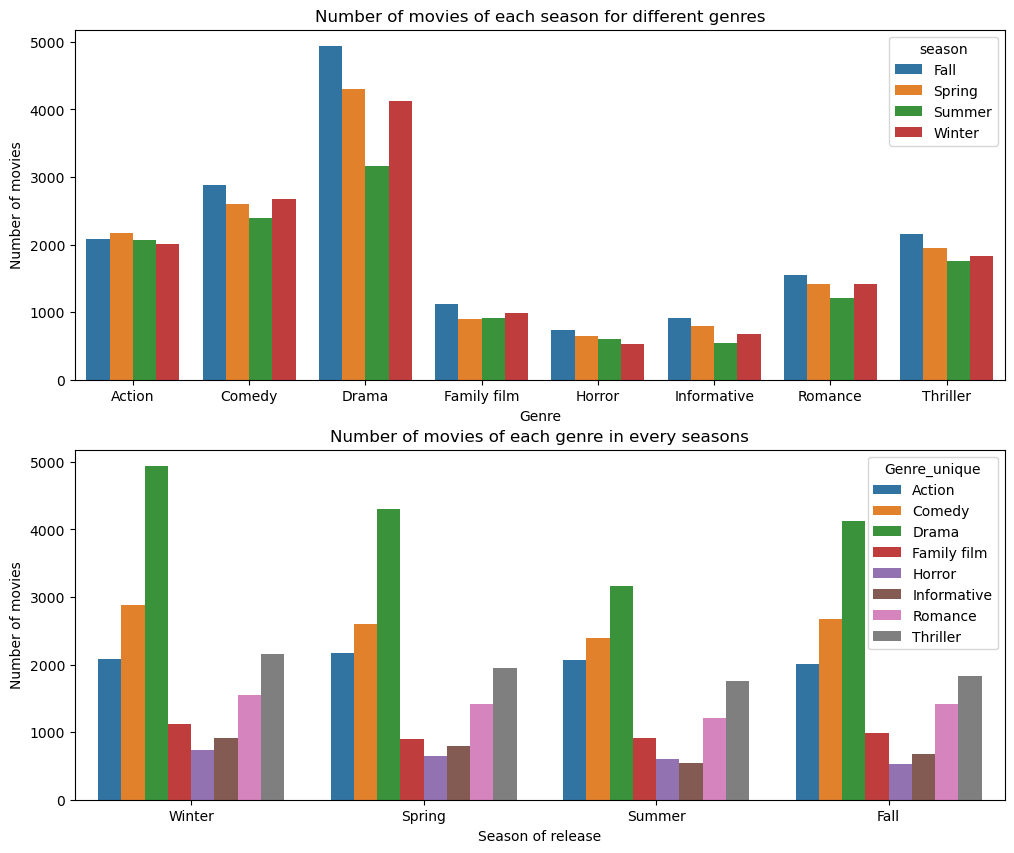

In [20]:
plot_general(df_movies)

The first histogram let us compare each genre with itself at every months. 
It is clear that most of the genres have less movies in summer than in others seasons, except for Action, Horror and Family film movies.

On the second plot, it is easier to compare each genre to other genres throughout the months.
There are indeed more informative movies than horror movies in Spring but the tendency is the opposite in Summer.

Both of these figure aren't showing some obvious pattern so we will continue with other kind of visualisation.

---
### **2. Looking for peaks in months for specific genres**
Let's look more deeply at specific genres individually, to see if there are redundancy peaks for certain months.



#### **2.1. Evolution of the number of Horror movies with months**

We first focus on the horror movies. Our goal is to determine if there are pics for certain months, or if the distribution is homogeneous. 

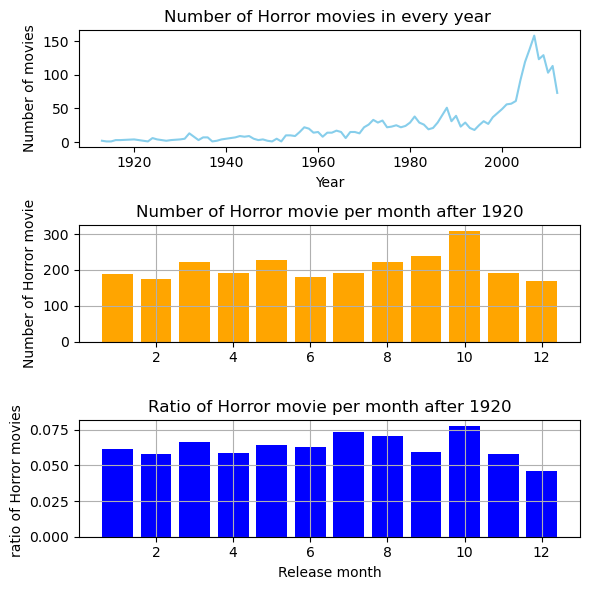

In [21]:
visu_P2(df_movies, 1920, 'Horror')

These plots show the total number of horror movies over the years and the number and ratio of horror movies per months. We decided to keep the movies after 1980 to have enough movies in each year. One can see a clear pic for the month of october.
This tends to show that the horror movies are more released in october which might be linked to Halloween.

Note : The ratio is defined by the number of horror movies in a specific month divided by the number of movies in that month.

#### **2.2. Evolution of the number of Family movies with months**

Here is the distribution of movies for the Family film genre.

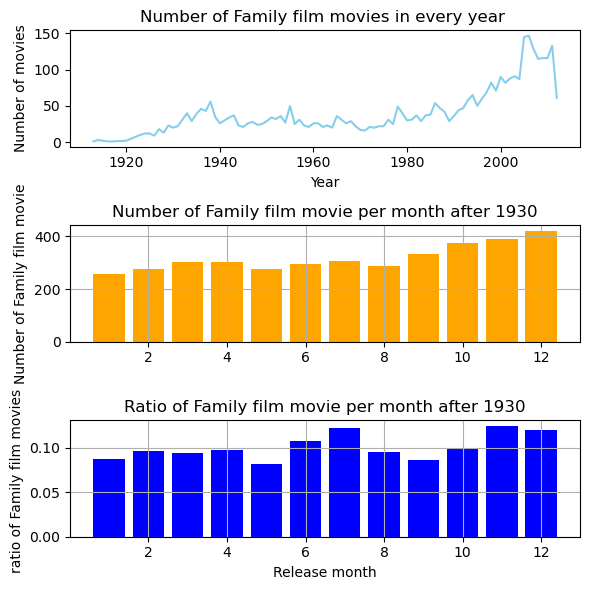

In [22]:
visu_P2(df_movies, 1930, 'Family film')

From the first plot, we decided to consider data from the years 1930, in order to have a consistent analysis with enough data. 

Then in the second and last plots, we can see several pics, one in July and then during Christmas time in November and December. There might be a pattern here which could be linked to the holidays in Summer and Christmas in November/December.

#### **2.3. Evolution of the number of Romance movies with months**

The following figure shows the distribution of the Romance movies

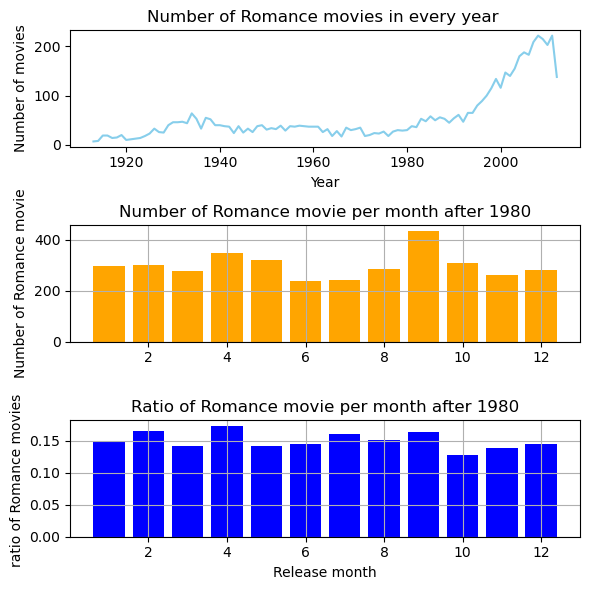

In [23]:
visu_P2(df_movies,1980, 'Romance')

From the first plot, we decided to consider data from the years 1980, in order to have a consistent analysis with enough data. 

The distribution is more homogenous here and we can not clearly see any pics, even if February and April seems to get more Romance movies than usual. It might be because of Valentine's Day!!

---
### **3. Evolution of the box office throughout the months**

It is also interesting to get a first sens at the distribution of box office revenue over the months, to determine if there is a special behavior.


In [24]:
#Remove the nan values of the box office revenue column
#Not removing it from the main dataframe 'df_movies' because it deletes a lot of data
df_box_office = df_movies.copy(deep = True)

df_box_office = df_box_office.dropna(subset=['Movie box office revenue'])

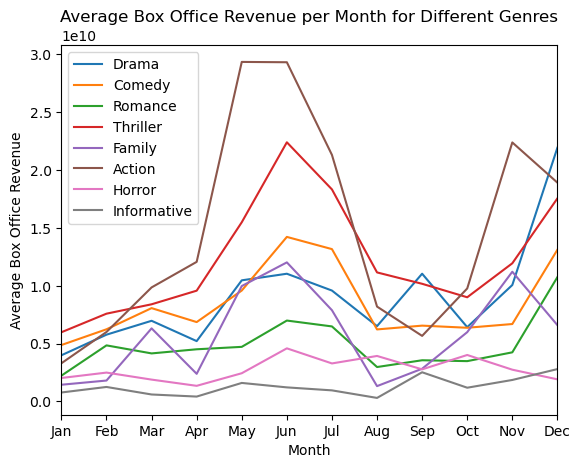

In [25]:
plot_average_monthly_revenue(df_box_office, percentage=False)

We can see that most of the genres succeed better in June and in December. However, we can also observe that some genres have singular peaks, such as the dramas in September. This curve is not so easy to interpret because some genres are, in general, more popular. Therefore, we plot the percentage of the box office represented by each genre every month, to see if some genres make significantly more profit compared to others in some months of the year. 

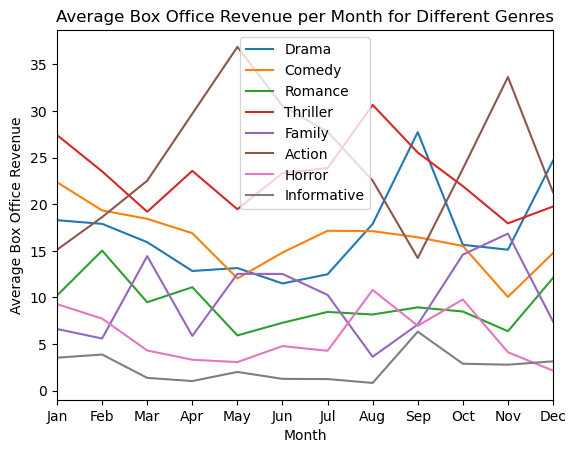

In [26]:
plot_average_monthly_revenue(df_box_office, percentage=True)

This representation allows us to observe results that were less visible in the last plot. For example we see that there is an important peak for action movies in May, when they represent over 35 percents of the total revenue.

Let's explore all of these observations to confirm these first impressions or check if there are simple coincidence. 

---
## Part 3: Hypothesis testing

We found interesting results regarding the number of movies per month for certain genres: Horror movies, Family films, and Romance movies. But simple histograms plots are not enough to confirm our intuition. Therefore, hypothesis testing are performed on these three genre to determine if the distribution of movies is really dependant on certain months.

---
### **1. Relation between the number of horror movies and the release month**
We noticed when plotting the number of horror movies per months a clear pick for the month of October. This assumption seems coherent since Halloween is the 31th of October! 



It could therefore be interesting to perform t-tests in order to reject the null hypothesis: 

H0: "Number of horror movies per year in October == Mean number of horror movies per year not in October."

Let's call the function 'ttest'. This function computes the respective means of the groups in october and not in october for all years, computes the p-value for the hypothesis testing, and also plots the number of horror movies per year for the two groups.

**Note:** From the plots of Part 2, it was found that before the year 1980, the number of horror movies is insufficient to perform a decent analysis, so the function discards the years before 1980.

The average number of Horror movies in ['Oct'] by year (after the year 1980 ) is: 7.42
The average number of Horror movies not in ['Oct'] by year (after the year 1980 ) is: 4.50
The p-value for the t-test is equal to 0.017663 so the null hypothesis is rejected.


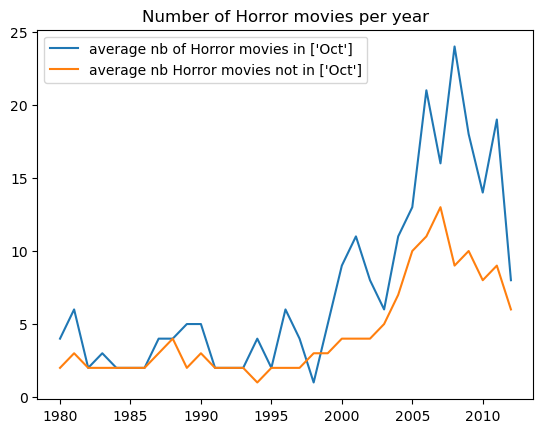

In [27]:
ttest(df_movies,'Horror', 10, 1980) #df, genre, month, min year considered (optional)

From the above plot and the result of the t-test, the difference in number of movies is statistically significant. 

---
### **2. Relation between the number of Family movies and the release month**
From the plots in Part 2, we noticed 3 pics for the months of July, November, and December. This tendency seems coherent since these periods correspond to holiday breaks.

Let's use again a t-test with the null hypothesis:

H0: "Mean of Family movies per year and per month for July, November, and December == Mean of Family movies per year and per months for all the other months."

**Note:** We consider here the data from all years (see plot of Part 2).

The average number of Family film movies in ['Jul' 'Nov' 'Dec'] by year (after the year 1930 ) is: 4.48
The average number of Family film movies not in ['Jul' 'Nov' 'Dec'] by year (after the year 1930 ) is: 3.62
The p-value for the t-test is equal to 0.064605 so the null hypothesis is not rejected.


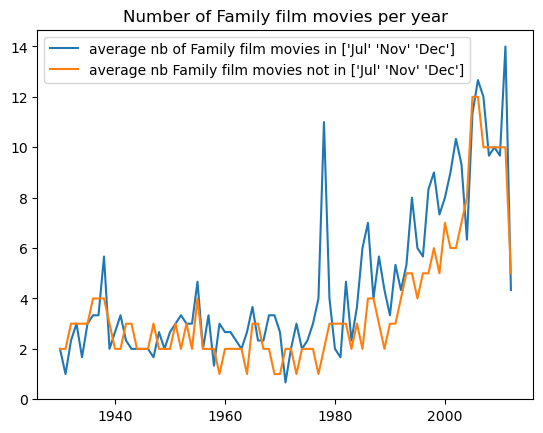

In [28]:
ttest(df_movies,'Family film', [7, 11, 12], 1930) #df, genre, month, min year considered (optional)

Here again the null hypothesis is rejected, even if the difference in the plots and in the means is less straight forward. 

---
### **3. Relation between the number of Romance and the release month**

From the plots in Part 2, we noticed 1 small pic for the month of February. This tendency seems coherent since this period corresponds to Valentine's day.

Let's use again a t-test with the null hypothesis:

H0: "Mean of Romance movies per year in February == Mean of Romance movies per year not in February."

**Note:** We consider here the data from the years 1980 (see plot of Part 2).

The average number of Romance movies in ['Feb'] by year (after the year 1980 ) is: 9.09
The average number of Romance movies not in ['Feb'] by year (after the year 1980 ) is: 9.08
The p-value for the t-test is equal to 1.000000 so the null hypothesis is not rejected.


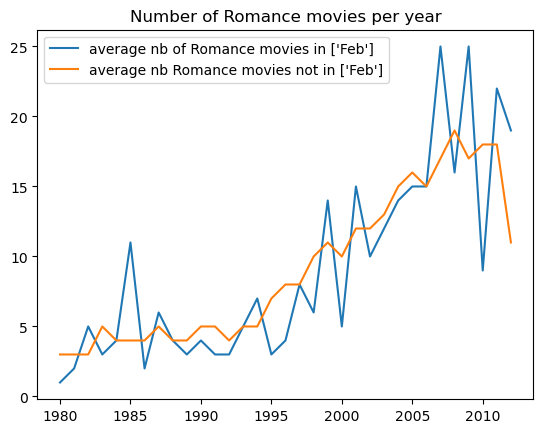

In [29]:
ttest(df_movies,'Romance', 2, 1980) #df, genre, month, min year considered (optional)

This time the difference is not statically significant, the null hypothesis is not rejected, so we conclude from this test that there is not more Romance movies in February.

---
## Part 4: Causal analysis, does the film industry support the time loop ?
In the previous part, we found significant result for the Horror and Family movie genres: for particular months, their number increases. The next step is to determine if these genres are more successful during their months of predilection.
In order to do this, we will check if releasing a Horror movie in October (Halloween is 31st of October) implies a greater box-office revenue. The same analysis will be done for Family films (in July, November and December).

---
### **1. Process the dataframe**

Some preprocessing needs to be done in order to know the distribution and proportion of the usable data. The features of interest are the budget, and the country of production.

#### **1.1. View on available budget data**

Let's make sanity checks in order to determine the global tendency of the features of interests within the dataset. 

The dataset used in this part is 'df_movies_merged', as it takes into account the budget.

In [30]:
#drop 48 countries that did not have country of release

df_movies_merged = df_movies_merged.dropna(subset=['continent_1'])

In [31]:
# Rename the 'Movie release year' so they are no spaces
df_movies_merged['Movie_release_year'] = df_movies_merged['Movie release year']

# Convert 'budget' column to float
df_movies_merged['budget'] = df_movies_merged['budget'].astype(float)

# Select only the rows which contain the budget 
df_movies_merged = df_movies_merged[df_movies_merged['budget' ] != 0]

# Count the movies for which the budget is known
nb_movies_with_budget = df_movies_merged['budget'].count()
print('There are',nb_movies_with_budget,'movies with the budget known.')

There are 4405 movies with the budget known.


This number seems satisfying for further analysis, the budget can then be taken into account.

#### **1.2. View on available country of release data**

In [32]:
nb_movies_northa = df_movies_merged[(df_movies_merged['continent_1'] == 1)]['continent_1'].count()
nb_movies_europe = df_movies_merged[(df_movies_merged['continent_1']==2)]['continent_1'].count()

percentage_northa_movies = 100 * nb_movies_northa/nb_movies_with_budget
percentage_europe_movies = 100 * nb_movies_europe/nb_movies_with_budget

print('The percentage of movies for which the budget is available, and which are produced in Northern America, is', round(percentage_northa_movies,2),'%.')
print('The percentage of movies for which the budget is available, and which are produced in Europe, is', round(percentage_europe_movies,2),'%.')


The percentage of movies for which the budget is available, and which are produced in Northern America, is 89.38 %.
The percentage of movies for which the budget is available, and which are produced in Europe, is 8.56 %.


As expected, the movies are mainly produced in Northern America. Only 8% are produced in Europe, but it is still quite a proportion. For further analysis, the country of production then still needs to be taken into account as a confounder.

Let's look now at the return of investment of movies for each continent of production.

In [33]:
#ratio_b_r = df_movies.groupby('continent_1').mean()['Movie box office revenue']/df_movies.groupby('continent_1').mean()['budget']
ratio_b_r = df_movies_merged.groupby('continent_1')['Movie box office revenue'].mean()/df_movies_merged.groupby('continent_1')['budget'].mean()
print("northa -> 1\nEurope -> 2\nsoutha -> 3\nAsia -> 4\nAfrica -> 5")
print('\nRatio of revenue over budget invested for different continents : \n', ratio_b_r)

northa -> 1
Europe -> 2
southa -> 3
Asia -> 4
Africa -> 5

Ratio of revenue over budget invested for different continents : 
 continent_1
1.0    3.251095
2.0    3.987839
3.0    2.663019
4.0    3.993641
5.0    3.293324
dtype: float64


The return on investment in Europe is a lot greater than in North America. \
So when analyzing the revenue, it makes sense to take into account the continent of release.

We will add a column in df 'Northern America' that is 1 if the production country is in Northern America, and 0 else.

In [34]:
# Create an extra column to identify treatment and control group directly in the main dataframe
def create_northa_column(row):
    return (1 if (row['continent_1']==1) else 0) # 1 being Northern America
df_movies_merged['Northern_America'] = df_movies_merged.apply(create_northa_column, axis = 1)

---
### **2. Horror movies revenue in October**
Now we can use the final dataframe to perform the paired matching. 



  **Treatment group** : Horror movies released in October

  **Control group** : Horror movies released in other months

**Confounders:**

  - We think the main bias would be that box office is influenced by when the big franchise movies are released. We’re interested in the success of horror movies in October regardless of how big the franchise is.
  To eliminate this bias, we take the budget as a feature.

  - Secondly, an important bias is the continent of release. In fact, Halloween is celebrated at different degree of popularity. For example, Russian people don't even celebrate it, whereas It is a big event in the USA.
  For that reason we might want to match movies with the same continent of release. 


  - Finally, we take into account the release year of the movie, to eliminate to influence of inflation over the years

  The features chosen to calculate the propensity score are the **Budget**, **release year** and **Country of release**. With the matched data, we will then observe if treated data has higher mean box office than control data.






##### **2.1. First overview of causality with unbalanced groups**

Let's take a look at the distribution of box office revenue first in a naive approach, without balancing the groups.

In [35]:
# Create the control and treatment group
horror_movies = df_movies_merged[((df_movies_merged['genre 1'] == 'Horror') | (df_movies_merged['genre 2'] == 'Horror'))]

#choosing Autumn
'''treatment = horror_movies[horror_movies['Movie release season']==4] # 4 being Autumn
control = horror_movies[horror_movies['Movie release season'] !=4]'''

#choosing October
treatment = horror_movies[horror_movies['Movie release month']==10] #10 being October
control = horror_movies[horror_movies['Movie release month'] !=10]

# Overview of the repartition of both groups before matching
nb_treatment_box_office = treatment['Movie box office revenue'].count()
nb_treatment_budget = treatment['budget'].count()

nb_control_box_office = control['Movie box office revenue'].count()
nb_control_budget = control['budget'].count()

print('There are',nb_treatment_box_office,'box office revenue available, and ',nb_treatment_budget,' budget available in the treatment group.')
print('There are',nb_control_box_office,'box office revenue available, and ',nb_control_budget,' budget available in the control group.')

There are 57 box office revenue available, and  75  budget available in the treatment group.
There are 322 box office revenue available, and  492  budget available in the control group.


This is not a lot of data if we want to extract tendencies with confidence, but it can still give relevant results.

In [36]:
# Drop row for which the box office revenue is unknown
horror_movies = horror_movies.dropna(subset=['Movie box office revenue'])

# Reset indexation
horror_movies = horror_movies.reset_index(drop=True)

In [37]:
# Create an extra column to identify treatment and control group directly in the main dataframe
def create_treat_column(row):
    return (1 if (row['Movie release month']==10) else 0) # 10 being October
horror_movies['treat'] = horror_movies.apply(create_treat_column, axis = 1)

Below is are the boxplots for the observed feature which is the box office revenue, as well as the confounders (budget and Movie release year).

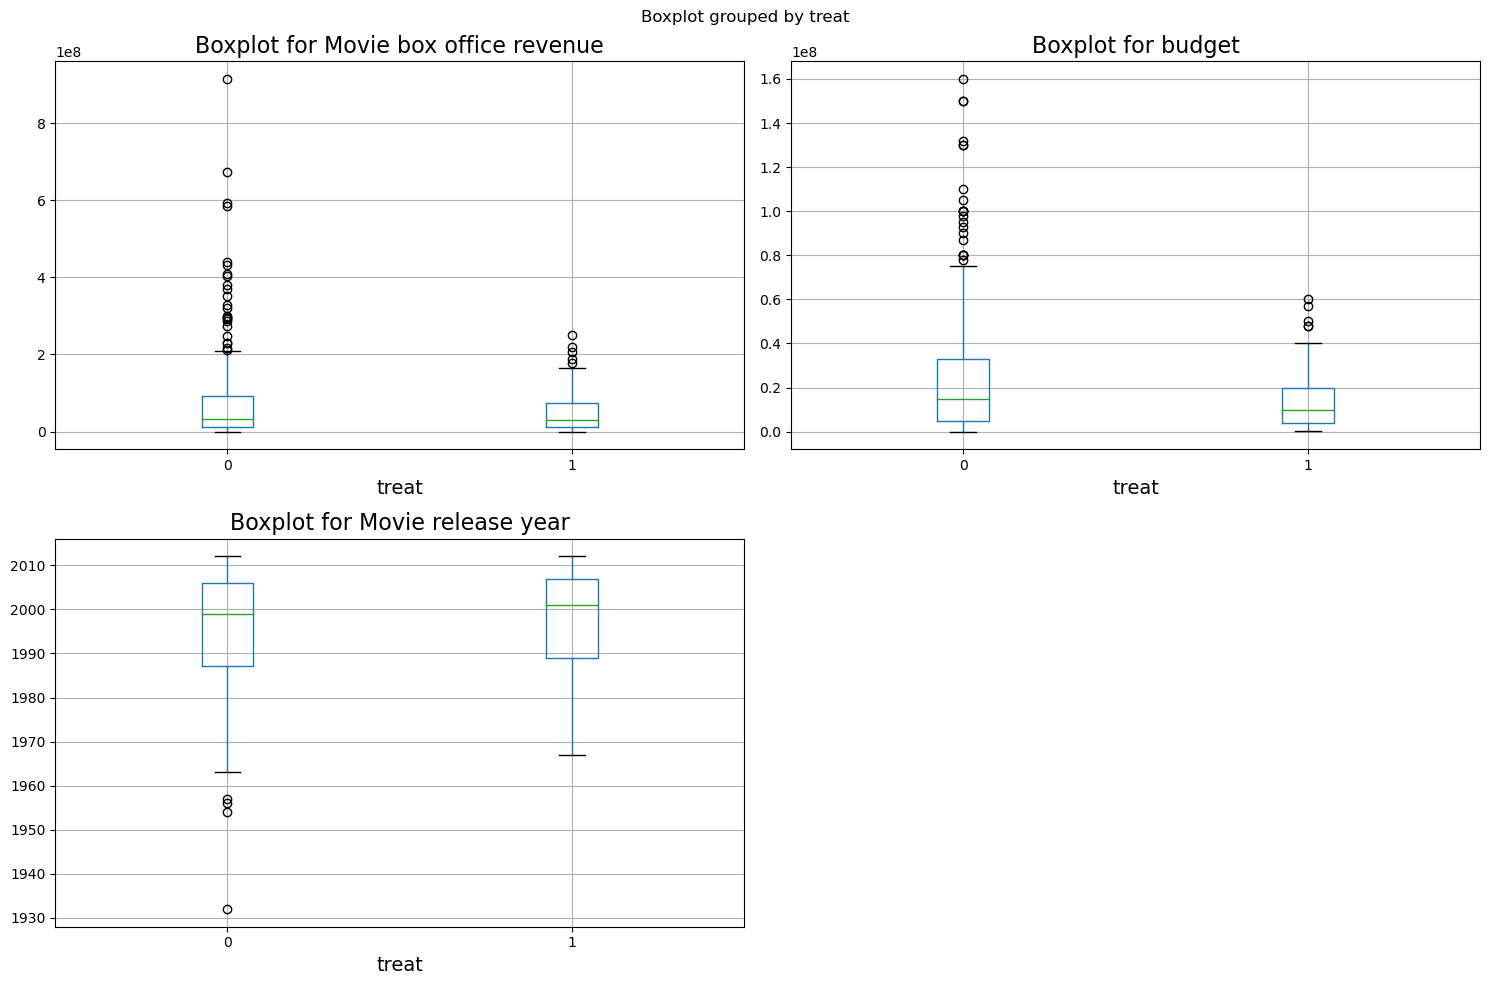

The mean Movie box office revenue for the treatment group is 57656925.04 , and its std is 64287627.22
The mean Movie box office revenue for the control group is 72077631.32 , and its std is 109017096.64


The mean budget for the treatment group is 11942508.0 , and its std is 14435429.89
The mean budget for the control group is 17789783.1 , and its std is 25531341.14


The mean Movie release year for the treatment group is 1996.53 , and its std is 13.07
The mean Movie release year for the control group is 1993.74 , and its std is 16.17




In [38]:
boxplots(horror_movies, treatment, control)

From these first visualizations, the following is noted:
- There is a better revenue for control group. This would mean that horror movies which are not released in October would be more successful? Let's not dive into too rapid conclusion, because this result might be due to unbalanced movies in terms of confounders...
- All the high-budget movies are in the control group. This could indeed explain the difference in revenue.
- The release year seems to be quite balanced between the two groups.

##### **2.2. Propensity score model**

Let's now balance our two groups in order to get unbiased results. A propensity score extracted from a logistic regression is computed.

In [39]:
#import statsmodels.api as sm

# let's standardize the continuous features
horror_movies['budget'] = (horror_movies['budget'] - horror_movies['budget'].mean())/horror_movies['budget'].std()
horror_movies['Movie_release_year'] = (horror_movies['Movie_release_year'] - horror_movies['Movie_release_year'].mean())/horror_movies['Movie_release_year'].std()

mod = smf.logit(formula='treat ~  budget + Movie_release_year + C(Northern_America)', data=horror_movies)

res = mod.fit()

# Extract the estimated propensity scores
horror_movies['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.408204
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  379
Model:                          Logit   Df Residuals:                      375
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.03588
Time:                        11:11:43   Log-Likelihood:                -154.71
converged:                       True   LL-Null:                       -160.47
Covariance Type:            nonrobust   LLR p-value:                  0.009245
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.9837      0.791     -2.508      0.012      -3.534

In [40]:
horror_movies['Propensity_score'].describe()

count    379.000000
mean       0.150396
std        0.058855
min        0.005889
25%        0.116325
50%        0.155142
75%        0.184363
max        0.284169
Name: Propensity_score, dtype: float64

##### **2.3. Paired matching**

We build pairs of treated and control movies based on their propensity scores. Moreover, in order to get even more accurate in the balancing, the release year is exactly matched.

In [41]:
balanced_horror_movies, balanced_treatment, balanced_control = paired_matching(horror_movies)

We visualize how much the pairing worked. Here we look at the repartition on our possibly main biais : Budget.

The mean budget for the treatment group is -0.3 , and its std is 0.57
The mean budget for the control group is -0.34 , and its std is 0.52


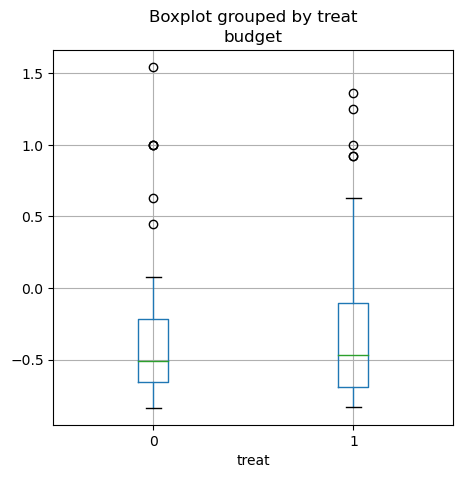

In [42]:
# Box plot of budget for treatment and control group after matching
balanced_horror_movies.boxplot(by='treat', column='budget', figsize = [5, 5], grid=True)

print_mean_std(balanced_treatment, balanced_control, 'budget')

plt.show()

Now let's look at the result of our observational experiment: the mean box office revenue for our control vs treatment group:

In [43]:
balanced_treatment['Movie box office revenue'].describe()

count    5.700000e+01
mean     5.765693e+07
std      6.428763e+07
min      5.260400e+04
25%      1.158289e+07
50%      3.085900e+07
75%      7.501940e+07
max      2.493489e+08
Name: Movie box office revenue, dtype: float64

In [44]:
balanced_control['Movie box office revenue'].describe()

count    5.700000e+01
mean     4.337293e+07
std      6.069117e+07
min      1.308390e+05
25%      8.279042e+06
50%      1.959503e+07
75%      4.148221e+07
max      2.879282e+08
Name: Movie box office revenue, dtype: float64

**Mean box-office revenue before and after matching**

Before Matching : 
- treated : 58.61 M$
- control : 73.52 M$

After Matching : 
- treated : 58.61 M$
- control : 42.35 M$


After matching, the mean box office revenue for the control group has drastically dropped, and became lower than the one of the treatment group. One can then confirm that a cause to success for Horror movies is a release date in October!

---
### **3. Family movies revenue in July, November, December**

In this part we'll perform the same type of matching but with the Family movies, our months of interest being July November and December. We want to determine if the success of a Family movie is caused by a release date in these months.



  **Treatment group** : Family movies released in July, November and December

  **Control group** : Family movies released in other months

  **Confounders:**

  - We think the main bias would be that box office is influenced by when the big franchise movies are released. We’re interested in the success of family movies in these months regardless of how big the franchise is.
  To eliminate this bias, we take the budget as a feature.

  - Secondly, an important bias is the continent of release. In fact, there can be a cultural bias and economic bias based on the country.

  - Finally, we take into account the release year of the movie, to eliminate to influence of inflation over the years

  The features chosen to calculate the propensity score are the **Budget**, **release year** and **Country of release**. With the matched data, we will then observe if treated data has higher mean box office than control data






Let's follow the same procedure as for Horror movies: look at the tendencies before balancing, then perform paired matching, and finally assess the results. 

##### **3.1. First overview of causality with unbalanced groups**

In [45]:
# Create the control and treatment group
family_movies = df_movies_merged[((df_movies_merged['genre 1'] == 'Family film') | (df_movies_merged['genre 2'] == 'Family film'))]


treatment = family_movies[((family_movies['Movie release month']==7) | (family_movies['Movie release month']==11) | (family_movies['Movie release month']==12))] # July/November/December 
control = family_movies[((family_movies['Movie release month']!=7) | (family_movies['Movie release month']!=11) | (family_movies['Movie release month']!=12))]

# Overview of the repartition of both groups before matching
nb_treatment_box_office = treatment['Movie box office revenue'].count()
nb_treatment_budget = treatment['budget'].count()

nb_control_box_office = control['Movie box office revenue'].count()
nb_control_budget = control['budget'].count()

print('There are',nb_treatment_box_office,'box office revenue available, and ',nb_treatment_budget,' budget available in the treatment group.')
print('There are',nb_control_box_office,'box office revenue available, and ',nb_control_budget,' budget available in the control group.')

There are 132 box office revenue available, and  163  budget available in the treatment group.
There are 363 box office revenue available, and  441  budget available in the control group.


Again, the number of movies is not optimal.

In [46]:
# Drop row for which the box office revenue is unknown
family_movies = family_movies.dropna(subset=['Movie box office revenue'])

# Reset indexation
family_movies = family_movies.reset_index(drop=True)

In [47]:
# Create an extra column to identify treatment and control group directly in the main dataframe
def create_treat_column(row):
    return (1 if ((row['Movie release month']==7) | (row['Movie release month']==11) | (row['Movie release month']==12)) else 0) # July, November, December
family_movies['treat'] = family_movies.apply(create_treat_column, axis = 1)

Below are the box office revenue, the budget, and the movie release year repartition between the two groups before paired matching.

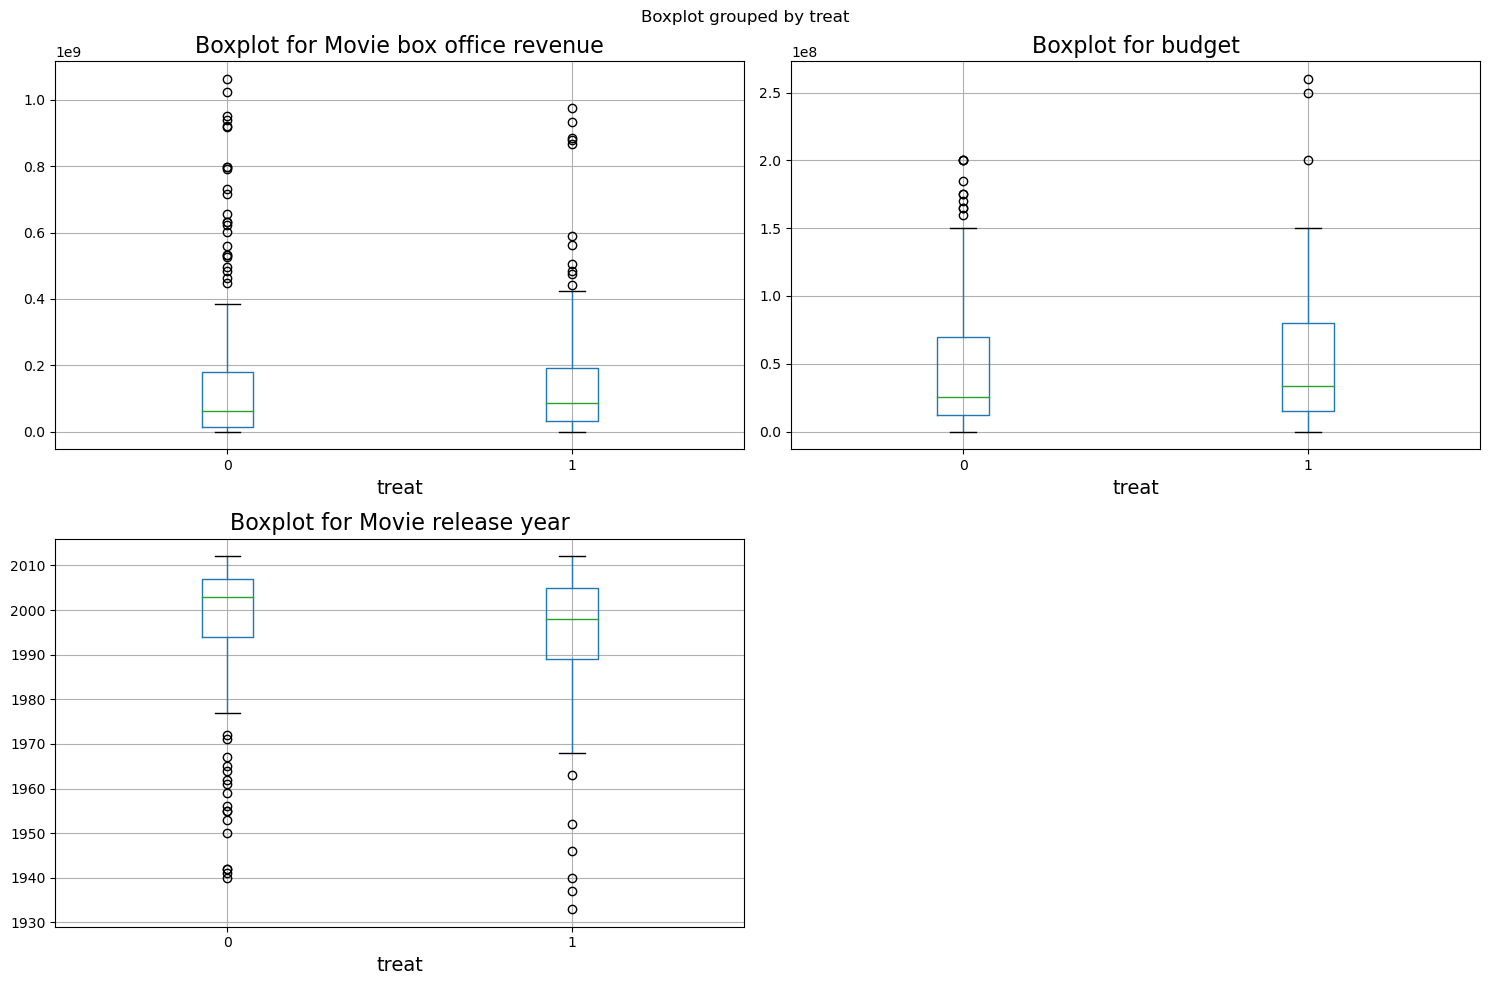

The mean Movie box office revenue for the treatment group is 159972581.49 , and its std is 198726793.36
The mean Movie box office revenue for the control group is 153108061.36 , and its std is 210527430.16


The mean budget for the treatment group is 48586021.15 , and its std is 49572354.71
The mean budget for the control group is 43637360.63 , and its std is 48855812.83


The mean Movie release year for the treatment group is 1994.21 , and its std is 16.33
The mean Movie release year for the control group is 1995.86 , and its std is 16.61




In [48]:
boxplots(family_movies, treatment, control)

From these first visualizations, the following is noted:
- There is a slight better revenue for treatment group. This would mean that family movies which are released in July, November, or December would be more successful? Let's not dive into too rapid conclusion, because this result might be due to unbalanced movies in terms of confounders...
- The mean budget for the treatment group is slightly higher than the control group, and outliers in treatment group are much higher. This could indeed explain the difference in revenue.
- The release year seems to be quite balanced between the two groups, although the mean for the control group is higher.

##### **3.2. Propensity score model**

Just as for horror movies, a propensity score is deduce from a logistic regression.

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

family_movies['Movie_release_year'] = family_movies['Movie release year']
# let's standardize the continuous features
family_movies['budget'] = (family_movies['budget'] - family_movies['budget'].mean())/family_movies['budget'].std()
family_movies['Movie_release_year'] = (family_movies['Movie_release_year'] - family_movies['Movie_release_year'].mean())/family_movies['Movie_release_year'].std()

mod = smf.logit(formula='treat ~  budget + Movie_release_year + C(Northern_America)', data=family_movies)

res = mod.fit()

# Extract the estimated propensity scores
family_movies['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.642612
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  363
Model:                          Logit   Df Residuals:                      359
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.01963
Time:                        11:12:11   Log-Likelihood:                -233.27
converged:                       True   LL-Null:                       -237.94
Covariance Type:            nonrobust   LLR p-value:                   0.02505
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4550      0.781     -1.864      0.062      -2.985

In [50]:
family_movies['Propensity_score'].describe()

count    363.000000
mean       0.363636
std        0.076571
min        0.133308
25%        0.317708
50%        0.356579
75%        0.401013
max        0.617475
Name: Propensity_score, dtype: float64

##### **3.3. Paired matching**

We then build pairs of treated and control movies based on their propensity scores. Additionally, an exact matching on the release year is performed.

In [51]:
balanced_family_movies, balanced_treatment, balanced_control = paired_matching(family_movies)

Let's check that the main bias (budget) is well balanced between the two groups after matching.

The mean budget for the treatment group is 0.09 , and its std is 1.01
The mean budget for the control group is 0.05 , and its std is 0.98


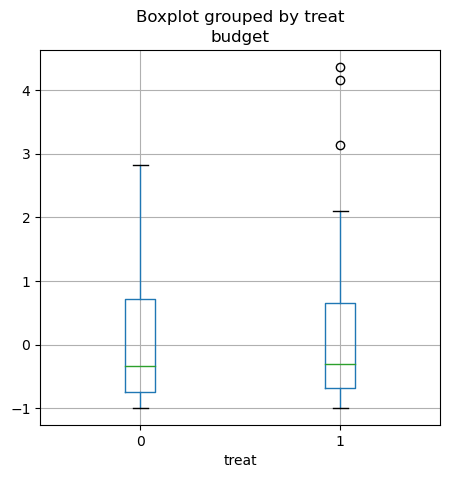

In [52]:
# Box plot of budget for treatment and control group
balanced_family_movies.boxplot(by='treat', column='budget', figsize = [5, 5], grid=True)

print_mean_std(balanced_treatment, balanced_control, 'budget')

plt.show()

The resulting distribution of budget between control and treatment seems satisfactory.

Now let's look if the resulting box office revenue for the two groups has changed:

In [53]:
balanced_treatment['Movie box office revenue'].describe()

count    1.320000e+02
mean     1.599726e+08
std      1.987268e+08
min      2.911180e+05
25%      3.166021e+07
50%      8.718591e+07
75%      1.927251e+08
max      9.747554e+08
Name: Movie box office revenue, dtype: float64

In [54]:
balanced_control['Movie box office revenue'].describe()

count    1.320000e+02
mean     1.753152e+08
std      2.278255e+08
min      7.136800e+04
25%      1.863056e+07
50%      8.600000e+07
75%      2.387009e+08
max      9.515838e+08
Name: Movie box office revenue, dtype: float64

Higher mean box office for control group.

**Mean box-office revenue before and after matching**

Before Matching : 
- treated : 161.10 M$
- control : 153.86 M$

After Matching : 
- treated : 161.10 M$
- control : 185.50 M$


After matching, the mean box office revenue for the control group has increased, and became higher than the one of the treatment group. One can then confirm that a releasing month in July, November, or December doesn't cause a better success for Family movies!

This is quite surprising, and contradicts the results just obtained for Horror movies. 

<span style="color:red;"> TROUVER UNE JUSTIFICATION</span>

## Machine Learning

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import json 
import ast
import random
import spacy

from scipy import stats
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from nltk.corpus import wordnet

#Scikit imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

# Load WordNet synsets for each season-related category
summer_synsets = wordnet.synsets('summer')
winter_synsets = wordnet.synsets('winter')
fall_synsets = wordnet.synsets('fall')
spring_synsets = wordnet.synsets('spring')
# Extract words from synsets
summer_words = set([lemma.name() for synset in summer_synsets for lemma in synset.lemmas()])
winter_words = set([lemma.name() for synset in winter_synsets for lemma in synset.lemmas()])
fall_words = set([lemma.name() for synset in fall_synsets for lemma in synset.lemmas()])
spring_words = set([lemma.name() for synset in spring_synsets for lemma in synset.lemmas()])
# Combine all seasonal words into one list
all_seasonal_words = list(summer_words.union(winter_words, fall_words))

# Filter the list to include only words found in WordNet
valid_seasonal_words = [word for word in all_seasonal_words if wordnet.synsets(word)]

# Print the valid seasonal words
#print("Valid Seasonal Words:", valid_seasonal_words)

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [102]:
with open('Data/plot_summaries.txt', 'r') as file:
    corpus = file.read()

lines_plots = corpus.strip().split('\n')

In [103]:
df_all = pd.read_csv('Data/movie.metadata.genres.tsv', sep = '\t')

In [223]:
from importlib import reload
reload(helpers2)
from helpers2 import*

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Lexicon explanation**

We first build up a lexicon linked to temporality. We do it with the help of ChatGPT, and we completed it by hand. We then expand it with the synonyms of the words already in. We end up with a lexicon containing over 1200 words, which are close to the topic we focus on. 

**Text processing**

Since one line of the document contains the id and the summary of one movie, we decide to process the whole text line by line. For each line we start by splitting it between the movieID and the summary, to save the movieID in a different array before performing the textual analysis on the summary. For each word of the summary, we frist check if its lemma belongs to our lexicon. If it does we add it to our list of tokens. This step performs lemmatization as well as "feature selection" : we only keep the words we are interested in and therefore avoid giving importance to the punctuation, to the parasite formatting expressions (for instance {{Plot}} written at the beginning of certain lines) and to irrelevant words, including the stopwords and the ones that are not linked to any of the temporality-related words we picked for our lexicon. At the end of this process, we add the movie to our bag-of-words only if it contains at least one of the words present in the lexicon. 

**MAT matrix handling** 

Since we are not particularly interested in words appearing in some specofic summaries only, we decide not to perform the tf-idf transformation. However, we still normalize each line of the BOW by the total number of words, to mitigate the variations of the summaries' length. The final step is to add the movieID column to this dataframe, to make the merging possible with movie.metadata.genres. 

This hole process is present in text_analisis function wright below

In [109]:
#Dataframe with occurences of specific words of each plot
lex = list()
lex = lexical()

MAT = text_analisis(lines_plots,lex,nlp, df_all)

display(MAT.head(5))

,Movie ID,acorn,adorn,affectionate,air,alert,allow,amor,amorous,animation,answer,antic,aplomb,appease,apple,ardent,aristocratic,assuage,autumn,autumnal,awe,ball,bamboozle,barbecue,be,...,warming,warmly,warmth,weather,white,whoremaster,whoremonger,wiccan,wide,will,windy,winter,wintertime,wise,witch,wonderland,woo,wordy,wraith,wrinkle,xmas,young,yule,zephyr,zest
0,23890098,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,31186339,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.452381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2231378,0.0,0.0,0.0,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.423077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,595909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,1952976,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.574468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.0


**Sentiment Analisis**

As in the tex processing we splitted the movieID and the summary in two different arrays. We perform a natural language processing on each lines. Then we apply SentimentIntensityAnalyzer which gives 'Positive', 'Negative', 'Neutral' and 'Compound' coefficients to each plot summary. This way we will know more or less the global sentiment of the movie and we guess that it will probably help in the season classification. We then stock all the results in a new data frame : df_sentiment

This section is presented bu sentiment_analisis function.


In [113]:
#Creation of the dataframe that will contain sentiment coefficient from each plot summaries
df_sentiment = pd.DataFrame(columns=['Movie_ID', 'Positive', 'Negative', 'Compound', 'Neutral'])
df_sentiment = sentiment_analisis(df_sentiment,lines_plots,nlp, df_all)

display(df_sentiment.head(5))

,Movie_ID,Positive,Negative,Compound,Neutral
0,23890098,0.084,0.083,0.0083,0.832
1,31186339,0.077,0.132,-0.9941,0.791
2,2231378,0.103,0.111,-0.6127,0.786
3,595909,0.067,0.108,-0.9538,0.825
4,1952976,0.070,0.084,-0.7904,0.846


In [131]:
df_clean_genre = pd.read_csv('Data/df_clean_genre.csv', sep=',', header=0)

#Create a dataframe with only the movie ID and the released season that will serve for the classification
df_season = df_clean_genre[['Wikipedia movieID', 'Movie release season']].copy(deep=True)
df_season = df_season[df_season['Wikipedia movieID'].isin(df_sentiment['Movie_ID'])]

#Sort both dataframe to have the same order of movie
df_sentiment_classification = pd.merge(df_season, df_sentiment, left_on='Wikipedia movieID', right_on='Movie_ID')

24147


In [147]:
#First Example of Logistic Regression classification only with Sentiment
df_sentiment_train, df_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(df_sentiment_classification.drop(['Movie_ID','Movie release season'], axis=1), df_sentiment_classification['Movie release season'], test_size=0.25, random_state=42)
  
model_LR =LogisticRegression(multi_class='ovr', random_state=42)#, n_estimators=150, random_state=42)  # Replace with your model of choice
model_LR.fit(df_sentiment_train, y_sentiment_train)

y_pred_sentiment_LR = model_LR.predict(df_sentiment_test)
accuracy_sentiment_LR = accuracy_score(y_sentiment_test, y_pred_sentiment_LR)
print(f'Model Accuracy: {accuracy_sentiment_LR}')

Model Accuracy: 0.28176246480039757


After having a few results of classification with only sentiments as features, we want to extand the number of features. We decide to add genre 1 and genre 2 as new features.

In [149]:
df_global_features = df_clean_genre.merge(df_sentiment, left_on='Wikipedia movieID', right_on='Movie_ID', how='inner')

#Select the features
columns_to_copy = ['Wikipedia movieID', 'Movie release season', 'genre 1', 'genre 2', 'Compound', 'Positive', 'Negative', 'Neutral']#,'Movie box office revenue', 'Movie runtime']
df_cleaned_features = df_global_features[columns_to_copy].copy(deep=True)

df_cleaned_features['genre 1'] = df_cleaned_features['genre 1'].astype(str)
df_cleaned_features['genre 2'] = df_cleaned_features['genre 2'].astype(str)

#Create boolean columns for each genre of genre 1 and 2 
df_cleaned_features = pd.get_dummies(df_cleaned_features, columns=['genre 1', 'genre 2'])
df_cleaned_features = df_cleaned_features.apply(pd.to_numeric, errors='ignore')

df_cleaned_features=df_cleaned_features.drop_duplicates(subset='Wikipedia movieID')


In [185]:
# We apply the same classification model than above to see the difference!

df_sentiment_genre_train, df_sentiment_genre_test, y_sentiment_genre_train, y_sentiment_genre_test = train_test_split(df_cleaned_features.drop(['Wikipedia movieID','Movie release season'], axis=1), df_cleaned_features['Movie release season'], test_size=0.25, random_state=42)
  
model_LR =LogisticRegression(multi_class='ovr', random_state=42)
model_LR.fit(df_sentiment_genre_train, y_sentiment_genre_train)

y_pred_genre_sentiment_LR = model_LR.predict(df_sentiment_genre_test)
accuracy_sentiment_genre_LR = accuracy_score(y_sentiment_genre_test, y_pred_genre_sentiment_LR)
print(f'Model Accuracy: {accuracy_sentiment_genre_LR}')

Model Accuracy: 0.27745568991220804


Final feature adding to our classification. We merge df_cleaned_feature and MAT to apply the model to a maximum of features!

In [186]:
df_text=MAT.drop_duplicates(subset='Movie ID')

In [187]:
df_text.rename(columns={'Movie ID': 'Wikipedia movieID'}, inplace=True)
df_merged = pd.merge(df_cleaned_features, df_text, on='Wikipedia movieID', how='inner')

df_merged = df_merged.dropna()

In [188]:
print(len(y_pred_genre_sentiment_LR))
print(len(y_sentiment_genre_test))

6037
6037


In [221]:
predictions = np.array(y_pred_genre_sentiment_LR)
test = np.array(y_sentiment_genre_test)

t_statistic, p_value, random_classifier_scores, model_scores= random_ttest(predictions, test)

print("p-value", p_value)
print(f"Accuracy: {accuracy_sentiment_genre_LR} p-value: {p_value} significant: {p_value < 0.05}")

p-value 0.0007068644290616563
Accuracy: 0.27745568991220804 p-value: 0.0007068644290616563 significant: True


In [224]:
### What would be significant ??

what_would_be_significant(random_classifier_scores, model_scores)

Accuracy: 0.25 p-value: 0.42376185480990514 significant: False
Accuracy: 0.26 p-value: 0.025397764834813485 significant: True
Accuracy: 0.27 p-value: 0.003482506095791334 significant: True
Accuracy: 0.28 p-value: 1.3750897248338126e-07 significant: True
Accuracy: 0.29 p-value: 1.322003513505438e-06 significant: True
Accuracy: 0.3 p-value: 2.496067610062568e-09 significant: True
Accuracy: 0.31 p-value: 1.2801955894591583e-13 significant: True
Accuracy: 0.32 p-value: 2.2580725774856675e-15 significant: True
Accuracy: 0.33 p-value: 4.486598071225325e-24 significant: True
Accuracy: 0.35 p-value: 2.8028273077003615e-32 significant: True


In [225]:
y = df_merged.iloc[:, 1]  
X = df_merged.iloc[:, 2:]

In [229]:
X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the Logistic Regression model
model_logreg = LogisticRegression(random_state=42, multi_class='ovr')
model_logreg.fit(X_LR_train, y_LR_train)

coefs=model_logreg.coef_[0]
top_five = np.argpartition(coefs, -10)[-10:]

# Make predictions on the test set
y_pred_logreg = model_logreg.predict(X_LR_test)
# Evaluate the accuracy of the Logistic Regression model
accuracy_logreg = accuracy_score(y_LR_test, y_pred_logreg)
#print("Logistic Regression Accuracy:", accuracy_logreg)

c:\Users\Dell\Downloads\Anaconda\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.2872555630478759


In [230]:
### Est ce qu'on garde alors que c'est moins bien???####

selected_columns = top_five
df_selected = X.iloc[:, selected_columns]

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(X.iloc[:, selected_columns], y, test_size=0.25, random_state=10)

# Create and train the Logistic Regression model
model_logreg = LogisticRegression(random_state=10, multi_class='ovr')
model_logreg.fit(X_LR_train, y_LR_train)#, sample_weight=sample_weights)

# Make predictions on the test set
y_pred_logreg = model_logreg.predict(X_LR_test)
# Evaluate the accuracy of the Logistic Regression model
accuracy_logreg = accuracy_score(y_LR_test, y_pred_logreg)
print("Logistic Regression Accuracy:", accuracy_logreg)

Logistic Regression Accuracy: 0.27596089008766017


In [232]:
predictions = np.array(y_pred_logreg)
test = np.array(y_LR_test)

t_statistic, p_value, random_classidier_scores, model_scores = random_ttest(predictions, test)

print("p-value", p_value)
print(f"Accuracy: {accuracy_logreg} p-value: {p_value} significant: {p_value < 0.05}")

p-value 0.010558640915639282
Accuracy: 0.27596089008766017 p-value: 0.010558640915639282 significant: True


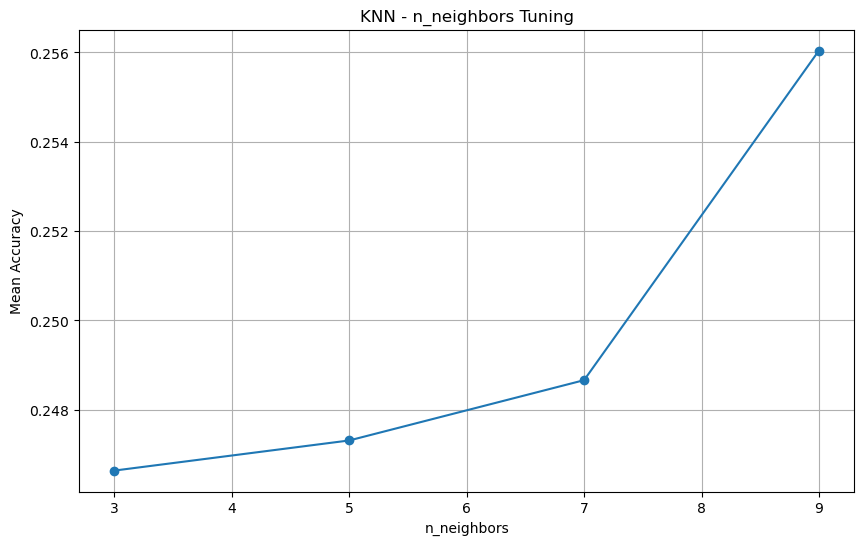

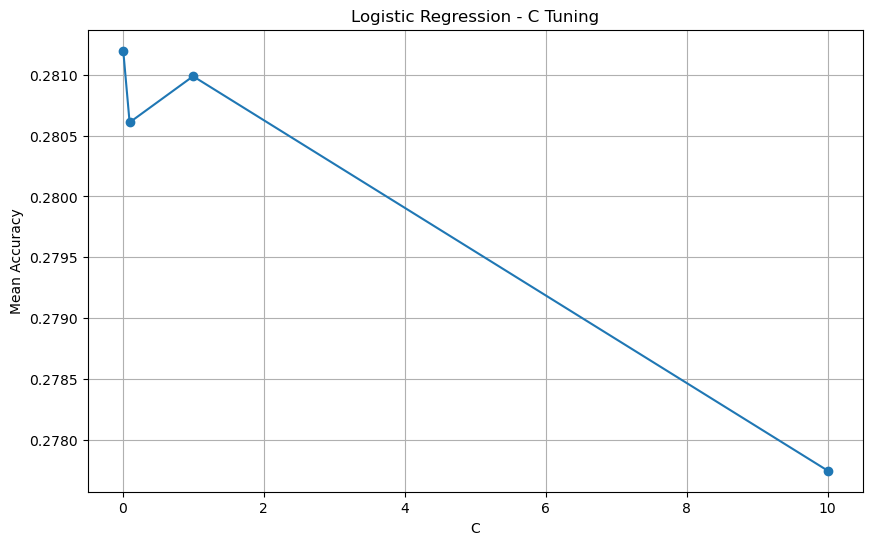

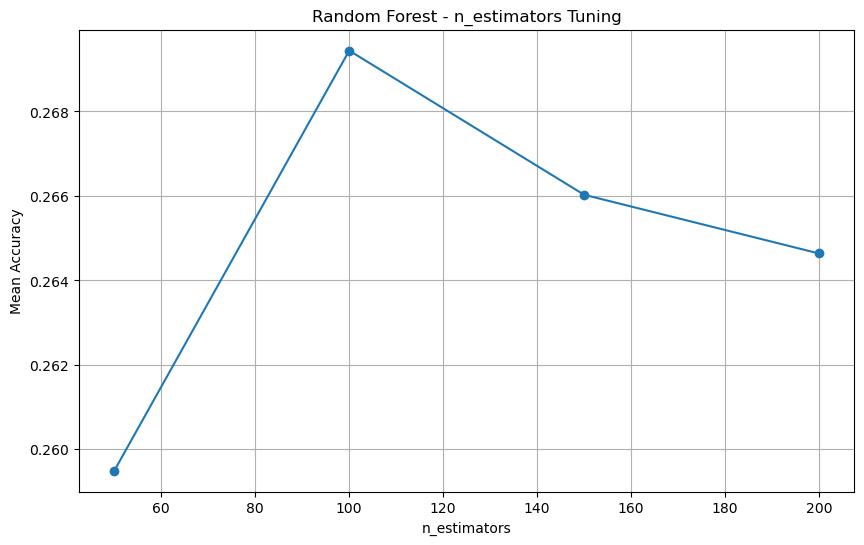

In [208]:
### Hyperparameter Tuning ###

# Hyperparameter tuning and plotting for KNN
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
tune_and_plot(KNeighborsClassifier(), knn_param_grid, 'KNN', 'n_neighbors', X, y)

# Hyperparameter tuning and plotting for Logistic Regression
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
tune_and_plot(LogisticRegression(max_iter=1000), logreg_param_grid, 'Logistic Regression', 'C', X, y)

rf_param_grid = {'n_estimators': [50,100,150,200]}
tune_and_plot(RandomForestClassifier(), rf_param_grid, 'Random Forest', 'n_estimators', X, y)

In [ ]:
### K-Fold Cross Validation ###

knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression(max_iter=1000,random_state=42,C = 1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

num_folds = 3  # You can adjust the number of folds as needed
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

knn_scores = cross_val_score(knn_model, X, Y, cv=kf, scoring='accuracy')
logreg_scores = cross_val_score(logreg_model, X, Y, cv=kf, scoring='accuracy')
rf_scores = cross_val_score(rf_model, X, Y, cv=kf, scoring='accuracy')

print(f'KNN Accuracy: {np.mean(knn_scores)} (std: {np.std(knn_scores)})')
print(f'Logistic Regression Accuracy: {np.mean(logreg_scores)} (std: {np.std(logreg_scores)})')
print(f'Random Forest Accuracy: {np.mean(rf_scores)} (std: {np.std(rf_scores)})')